## Final assignment part 1/2 - Preparing ecoregion data

Find an introduction to this project in attached README file. 

Data download instructions are found in README file for:
- Europe Forest Area raster 
- World Terrestrial Ecoregions 
- World countries (ready in data/europemask folder)

Here we go:


In [1]:
import geopandas as gpd
import pandas as pd
from pyproj import CRS
import numpy as np
import os
import fiona

import matplotlib.pyplot as plt
from shapely.geometry import Polygon, MultiPolygon
from shapely.geometry import box
import json

In [2]:
# create necessary paths
# downloading data to folders manually! See instructions and download links in README file

os.chdir('data')

# Create directory
dirNames = ['ecoregions', 'ecoregions_subset', 'forest']

for dirName in dirNames:
    try:
        # Create target Directory
        os.mkdir(dirName)
        print("Directory " , dirName ,  " Created ") 
    except FileExistsError:
        print("Directory " , dirName ,  " already exists")
    
os.chdir('../')

Directory  ecoregions  Created 
Directory  ecoregions_subset  Created 
Directory  forest  Created 


In [3]:
# read in ecoregion data
# (after downloadind data! Instructions in the README file. )
ecoreg = gpd.read_file('data/ecoregions/tnc_terr_ecoregions.shp')

%matplotlib inline

fig, ax = plt.subplots(figsize=(14,9))
ecoreg.plot(ax=ax, column='ECO_NAME', cmap= 'Pastel2')
ax.set_title('World ecoregions');

# set crs same as in forest cover raster
ecoreg = ecoreg.to_crs(CRS.from_epsg(3035)); 


DriverError: data/ecoregions/tnc_terr_ecoregions.shp: No such file or directory

In [3]:
# read in world countries for ecoregion EUROPE MASK 
countries = gpd.read_file('data/europemask/ne_10m_admin_0_countries.shp')
# remove all but necessary columns
countries = countries[['NAME', 'CONTINENT', 'geometry']]


## Subset to only European ecoregions

In [4]:
# subset to those European countries that are represented in forest cover raster
europe = countries.loc[countries['CONTINENT']== "Europe"]
europe = europe.loc[~europe['NAME'].isin(['Russia', 'Ukraine', 'Belarus'])]

# set crs same as in forest cover raster
europe = europe.to_crs(CRS.from_epsg(3035))


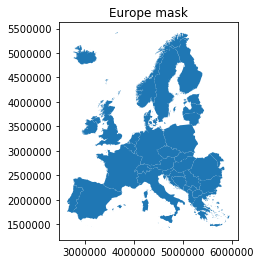

In [9]:
#create bounding box framing Europe

bbox = box(2500000,  900000 ,6550000, 5500000)
bbox = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs= CRS.from_epsg(3035))


# Subset Europe layer to match the box. This excludes small islands and areas on other continents, like French Guayana.

europe_mask = gpd.overlay(europe, bbox, how='intersection')
ax = europe_mask.plot()
ax.set_title('Europe mask');

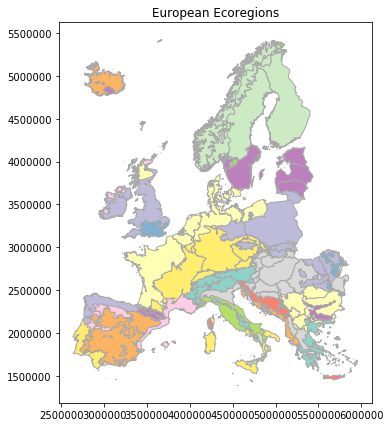

In [16]:
# overlay world ecoregion data with Europe mask
ecoreg_eu = gpd.overlay(europe_mask, ecoreg, how='intersection')

# visualize
ax = ecoreg_eu.plot(column = 'ECO_NAME', cmap = 'Set3', figsize=(6,7), edgecolor= 'darkgrey')
ax.set_title('European Ecoregions - multiple geometries');

### Combine geometries that were shattered by overlay

As we see, in overlayed data the ecoregions are distributed to multiple rows of geometries.  
We want there to be only **one** geometry per ecoregion, the same way as in the original ecoregion data.  
To get there, we combine polygons of overlayed data to new dataframe:  


In [20]:
# empty lists to store data of new complete ecoregions 
geometry_new = []
eco_name = []

# group overlayed data by ecoregion names
grouped = ecoreg_eu.groupby(by='ECO_NAME')    

for key, group in grouped:    
    
    glist = [] # polygon list for new MultiPolygon geometry
    
    # loop through geometries of one ecoregion and add polygons to list
    for geom in group['geometry']:   
        if geom.geom_type == 'MultiPolygon': # Multipolygon has to be added to list in a different way than single polygons
            glist = glist + list(geom)
        elif geom.geom_type == 'Polygon':
            glist.append(geom)

    newgeom = MultiPolygon(glist) # Polygons into one Multipolygon
    
    geometry_new.append(newgeom)   # store new single ecoregion geometry
    eco_name.append(key)           # store respective ecoregion name


# new ecoregion data with single geometries    
new_ecoreg = gpd.GeoDataFrame(geometry=geometry_new, 
                              crs={'init': 'epsg:3035'})
new_ecoreg['ECO_NAME'] = eco_name


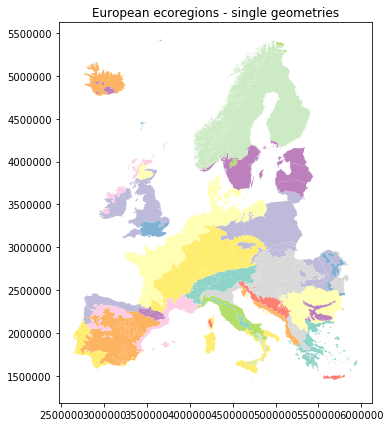

In [23]:
ax= new_ecoreg.plot(column = 'ECO_NAME', cmap = 'Set3', figsize=(6,7))
ax.set_title('European ecoregions - single geometries');

  

## Subset to Ecoregions that are named as some kinds of "Forest"  



In [27]:
# subset to only ecoregions that are naturally covered by forest
forest_ecoregs = new_ecoreg[new_ecoreg['ECO_NAME'].str.contains("forest|taiga", case = False)] # ecoregion is named "forest" or "taiga"

# Remove manually ecoregions that are named as forests but are not very forest like
forest_ecoregs =  forest_ecoregs[~forest_ecoregs['ECO_NAME'].isin(['Scandinavian Montane Birch Forest And Grasslands',
                                                                    'Iceland Boreal Birch Forests And Alpine Tundra',
                                                                      'East European Forest Steppe'])]

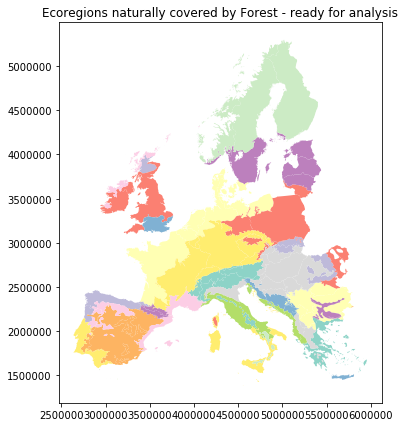

In [32]:
# Visualize the ecoregions used in analyses (european forests)
ax = forest_ecoregs.plot(column = 'ECO_NAME', cmap = 'Set3', figsize=(6,7))
ax.set_title('Ecoregions naturally covered by Forest - ready for analysis');


In [29]:
# Write prepared ecoregion data into a shapefile
forest_ecoregs.crs = CRS.from_epsg(3035).to_wkt()
forest_ecoregs.to_file('data/ecoregions_subset/forest_ecoregs.shp')

#### Ready to analyze!  -> 2/2